In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.interpolate
import scipy.optimize
%matplotlib notebook

In [2]:
sorted(os.listdir('data/A344/dat'))

['A344_GdN_FC_050_Oe_160908.rso.dat',
 'A344_GdN_FC_500_Oe_160908.rso.dat',
 'A344_GdN_MH_005K_160905.rso.dat',
 'A344_GdN_MH_010K_160905.rso.dat',
 'A344_GdN_MH_010K_160908.rso.dat',
 'A344_GdN_MH_020K_160905.rso.dat',
 'A344_GdN_MH_020K_160908.rso.dat',
 'A344_GdN_MH_030K_160908.rso.dat',
 'A344_GdN_MH_040K_160905.rso.dat',
 'A344_GdN_MH_050K_160905.rso.dat',
 'A344_GdN_MH_055K_160905.rso.dat',
 'A344_GdN_MH_060K_160905.rso.dat',
 'A344_GdN_MH_065K_160905.rso.dat',
 'A344_GdN_MH_070K_160905.rso.dat',
 'A344_GdN_MH_075K_160905.rso.dat',
 'A344_GdN_ZFC_050_Oe_160908.rso.dat',
 'A344_GdN_ZFC_500_Oe_160908.rso.dat',
 'A344_cool_zero_field_050_160908.rso.dat',
 'A344_cool_zero_field_500_160908.rso.dat']

In [3]:
# Using numpy to parse csv formatted data file)
fc_data = np.genfromtxt('data/A344/dat/A344_GdN_FC_050_Oe_160908.rso.dat',
                    delimiter = ',', skip_header = 30, names = True)

In [4]:
# Column names taken from the data file
fc_data.dtype.names

('Time',
 'Comment',
 'Field_Oe',
 'Temperature_K',
 'Long_Moment_emu',
 'Long_Scan_Std_Dev',
 'Long_Offset_cm',
 'Long_Offset_Std_Dev',
 'Long_Algorithm',
 'Long_Reg_Fit',
 'Long_Reg_Factor',
 'Trans_Moment_emu',
 'Trans_Scan_Std_Dev',
 'Trans_Offset_cm',
 'Trans_Offset_Std_Dev',
 'Trans_Algorithm',
 'Trans_Reg_Fit',
 'Trans_Reg_Factor',
 'Long_Moment_wo_ABS_emu',
 'Long_Scan_Std_Dev_wo_ABS',
 'Long_Offset_wo_ABS_cm',
 'Long_Offset_Std_Dev_wo_ABS',
 'Long_Reg_Fit_wo_ABS',
 'Trans_Moment_wo_ABS_emu',
 'Trans_Scan_Std_Dev_wo_ABS',
 'Trans_Offset_wo_ABS_cm',
 'Trans_Offset_Std_Dev_wo_ABS',
 'Trans_Reg_Fit_wo_ABS',
 'RSO_Position_deg',
 'Amplitude_cm',
 'Frequency',
 'Cycles_to_Average',
 'Scans_per_Measurement',
 'Delta_Temp_K',
 'Error',
 'EC_Comp_Running',
 'Using_ABS',
 'f0')

<IPython.core.display.Javascript object>


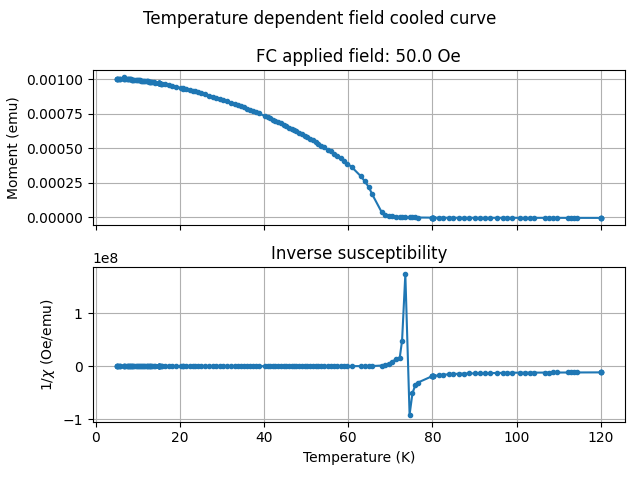

In [5]:
# setting up figure with two axes to compare magnetic moment and inverse suscepbility
fig1, (ax1a, ax1b) = plt.subplots(2, 1, sharex = True)
#fig1.set_size_inches(6, 8)
fig1.suptitle('Temperature dependent field cooled curve')
ax1a.set_title(f'FC applied field: {fc_data["Field_Oe"].mean():.1f} Oe')
ax1b.set_title('Inverse susceptibility')
ax1a.set_ylabel('Moment (emu)')
ax1b.set_xlabel('Temperature (K)')
ax1b.set_ylabel(r'1/$\chi$ (Oe/emu)')
ax1a.grid(True)
ax1b.grid(True)
ax1a.plot(fc_data['Temperature_K'], fc_data['Long_Moment_emu'], marker = '.')
ax1b.plot(fc_data['Temperature_K'], fc_data['Field_Oe']/fc_data['Long_Moment_emu'], marker = '.')
plt.tight_layout()
plt.draw()

<IPython.core.display.Javascript object>


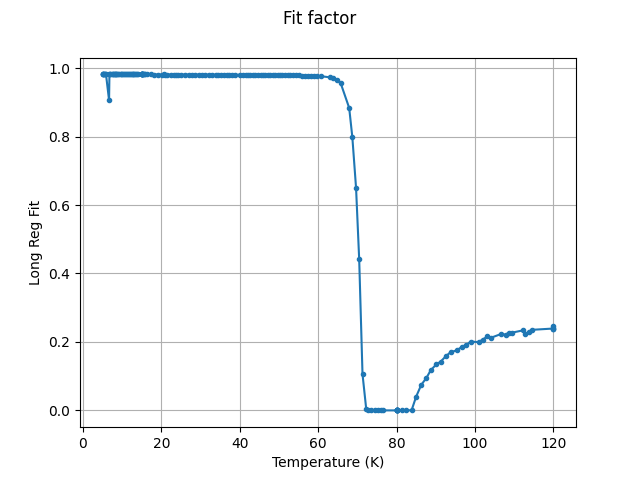

In [6]:
fig2, ax2 = plt.subplots(1, 1)
fig2.suptitle('Fit factor')
ax2.set_xlabel('Temperature (K)')
ax2.set_ylabel('Long Reg Fit')
ax2.grid(True)
ax2.plot(fc_data['Temperature_K'], fc_data['Long_Reg_Fit'], marker = '.')

In [7]:
mh_data_5k = np.genfromtxt('data/A344/dat/A344_GdN_MH_005K_160905.rso.dat',
                    delimiter = ',', skip_header = 30, names = True)

<IPython.core.display.Javascript object>


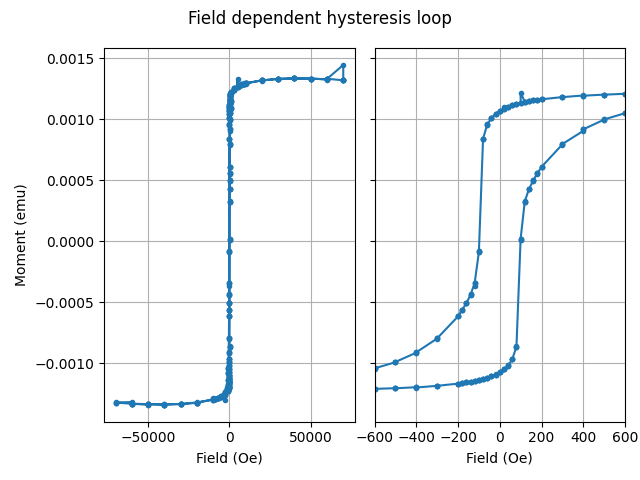

In [8]:
fig3, (ax3a, ax3b) = plt.subplots(1, 2, sharey = True)
fig3.suptitle('Field dependent hysteresis loop')
ax3a.set_xlabel('Field (Oe)')
ax3b.set_xlabel('Field (Oe)')
ax3a.set_ylabel('Moment (emu)')
ax3a.grid(True)
ax3b.grid(True)
ax3a.plot(mh_data_5k['Field_Oe'], mh_data_5k['Long_Moment_emu'], marker = '.')
ax3b.plot(mh_data_5k['Field_Oe'], mh_data_5k['Long_Moment_emu'], marker = '.')
ax3b.set_xlim(-600, 600)
plt.tight_layout()

<IPython.core.display.Javascript object>


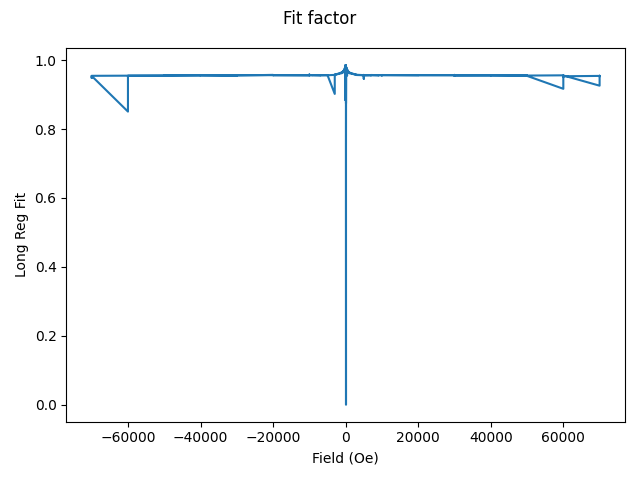

In [9]:
fig4, ax4 = plt.subplots()
fig4.suptitle('Fit factor')
ax4.plot(mh_data_5k['Field_Oe'], mh_data_5k['Long_Reg_Fit'])
ax4.set_xlabel('Field (Oe)')
ax4.set_ylabel('Long Reg Fit')
plt.tight_layout()

In [10]:
# Sample details needed to convert from magnetic moment to magnetization (emu/cm^3 or mu_b/magnetic ion)
# Substrate susceptibility used to subtract diamagnetic background contribution
sample_mass              = 0.0105         # g
substrate_thickness      = 0.028          # cm
substrate_density        = 2.328          # g/cm^3
substrate_susceptibility = -2.968e-07     # emu/Oe/cm^3, diamagnetic Si
film_thickness           = 4.3e-6         # cm
n_density                = 4/(4.98e-8)**3 # Gd/cm^3

substrate_volume = sample_mass/substrate_density        # cm^3
substrate_area   = substrate_volume/substrate_thickness # cm^2
film_volume      = substrate_area * film_thickness      # cm^3
n_gd             = n_density * film_volume              # atoms
mu_b             = 9.724009994e-21                      # emu
cf               = 1/(n_gd * mu_b)                      # mu_b/Gd/emu
print(f'Number of Gd atoms in film: {n_gd:.2e}')

Number of Gd atoms in film: 2.24e+16


In [11]:
# curie weiss with correction for constant moment offset
k_B = 1.380649e-16 # erg/K
mu_B = 9.274009994e-21 # erg/G, emu
# gd ion
g = 2
J = 7/2
mu_eff = mu_b * g * np.sqrt(J*(J + 1))
print(f'Gd ion effective moment: {mu_eff:.3e} emu')

Gd ion effective moment: 7.718e-20 emu


<IPython.core.display.Javascript object>


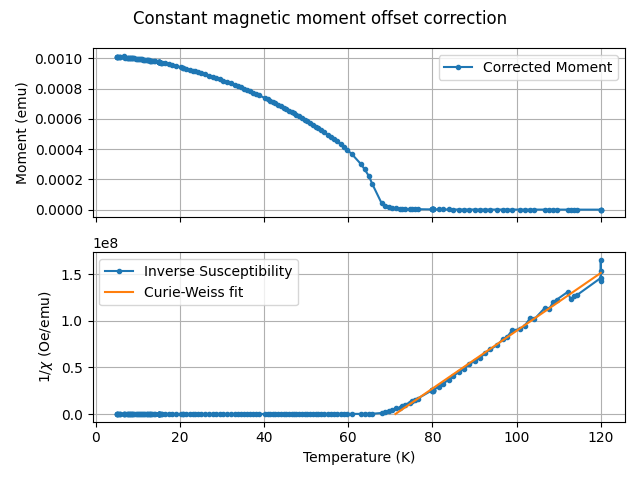

Subtracting constant moment offset: -4.627e-06 emu
T_C = 71.21 K
N_Gd = 2.24e+16


In [12]:
# setting up figure with two axes to compare magnetic moment and inverse suscepbility
fig5, (ax5a, ax5b) = plt.subplots(2, 1, sharex = True)
#fig5.set_size_inches(6, 8)
fig5.suptitle('Constant magnetic moment offset correction')
ax5a.set_ylabel('Moment (emu)')
ax5b.set_xlabel('Temperature (K)')
ax5b.set_ylabel(r'1/$\chi$ (Oe/emu)')
ax5a.grid(True)
ax5b.grid(True)

temperature = fc_data['Temperature_K']
# arbitrary correction for negative moment at high temperature
M_c = 1.07*fc_data['Long_Moment_emu'].min()
moment = fc_data['Long_Moment_emu'] - M_c

applied_field = fc_data['Field_Oe'].mean()
inv_susc = fc_data['Field_Oe']/moment
ax5a.plot(temperature, moment, marker = '.', label = 'Corrected Moment')
ax5b.plot(temperature, inv_susc, marker = '.', label = 'Inverse Susceptibility')

# linear fit to high temperature data
idx = temperature > 90
m, c = np.polyfit(temperature[idx], inv_susc[idx], 1)
T_C = -c/m
cw = np.poly1d([m, c])
ax5b.plot([T_C, temperature.max()], cw([T_C, temperature.max()]), label = 'Curie-Weiss fit')
ax5a.legend()
ax5b.legend()

plt.tight_layout()

print(f'Subtracting constant moment offset: {M_c:.3e} emu')
print(f'T_C = {-c/m:.2f} K')
print(f'N_Gd = {3*k_B/(mu_eff**2 * m):.2e}')

<IPython.core.display.Javascript object>


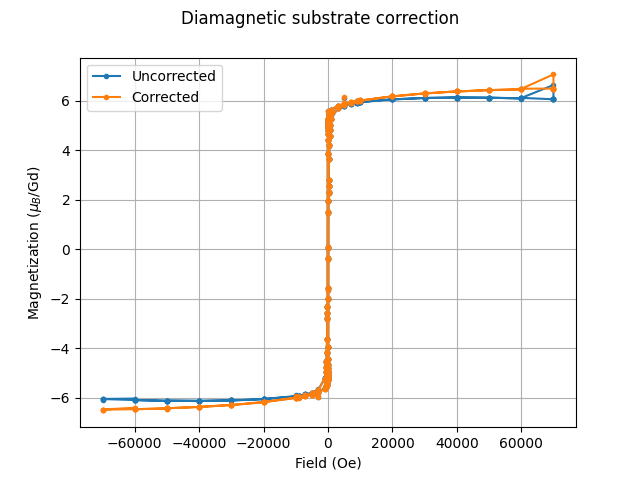

In [13]:
field = mh_data_5k['Field_Oe']
moment = mh_data_5k['Long_Moment_emu']
substrate_moment = substrate_susceptibility * substrate_volume * field
corrected_moment = moment - substrate_moment
fig6, ax6 = plt.subplots(1, 1)
fig6.suptitle('Diamagnetic substrate correction')
ax6.plot(field, cf*moment, marker = '.', label = 'Uncorrected')
ax6.plot(field, cf*corrected_moment, marker = '.', label = 'Corrected')
ax6.set_xlabel('Field (Oe)')
ax6.set_ylabel(r'Magnetization ($\mu_B$/Gd)')
ax6.legend()
ax6.grid(True)

In [14]:
mh_data_files = sorted('data/A344/dat/' + fname
                       for fname in os.listdir('data/A344/dat') 
                       if 'MH' in fname)

In [15]:
mh_data_files

['data/A344/dat/A344_GdN_MH_005K_160905.rso.dat',
 'data/A344/dat/A344_GdN_MH_010K_160905.rso.dat',
 'data/A344/dat/A344_GdN_MH_010K_160908.rso.dat',
 'data/A344/dat/A344_GdN_MH_020K_160905.rso.dat',
 'data/A344/dat/A344_GdN_MH_020K_160908.rso.dat',
 'data/A344/dat/A344_GdN_MH_030K_160908.rso.dat',
 'data/A344/dat/A344_GdN_MH_040K_160905.rso.dat',
 'data/A344/dat/A344_GdN_MH_050K_160905.rso.dat',
 'data/A344/dat/A344_GdN_MH_055K_160905.rso.dat',
 'data/A344/dat/A344_GdN_MH_060K_160905.rso.dat',
 'data/A344/dat/A344_GdN_MH_065K_160905.rso.dat',
 'data/A344/dat/A344_GdN_MH_070K_160905.rso.dat',
 'data/A344/dat/A344_GdN_MH_075K_160905.rso.dat']

<IPython.core.display.Javascript object>


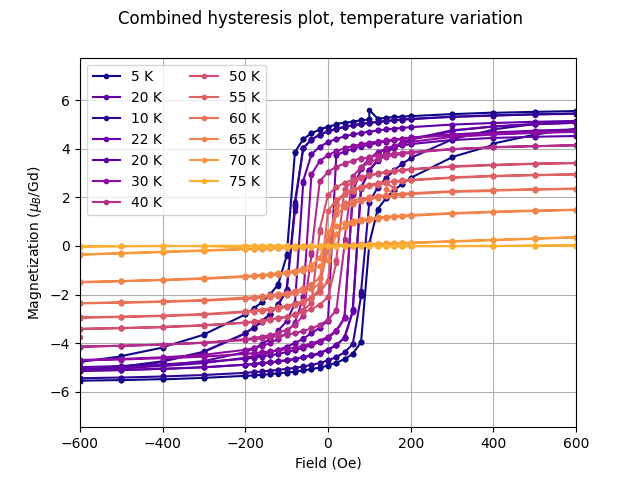

In [16]:
fig7, ax7 = plt.subplots(1, 1)
#fig7.set_size_inches(8,6)
fig7.suptitle('Combined hysteresis plot, temperature variation')
ax7.grid()
# Using matplotlib colormaps to colour lines depending on temperature 
cmap = plt.get_cmap('plasma')
norm = mpl.colors.Normalize(vmin = 5, vmax = 90)
for file in mh_data_files:
    mh_data = np.genfromtxt(file,
                    delimiter = ',', skip_header = 30, names = True)
    temperature = round(mh_data['Temperature_K'].mean())
    #mh_data = mh_data[mh_data.shape[0]//2:]
    substrate_moment = substrate_susceptibility * substrate_volume * mh_data['Field_Oe']
    ax7.plot(mh_data['Field_Oe'], cf*(mh_data['Long_Moment_emu'] - substrate_moment),
             marker = '.', label = f'{temperature} K', color = cmap(norm(temperature)))
ax7.set_xlabel('Field (Oe)')
ax7.set_ylabel(r'Magnetization ($\mu_B$/Gd)')
ax7.set_xlim(-600, 600)
ax7.legend(ncol = 2)

<IPython.core.display.Javascript object>


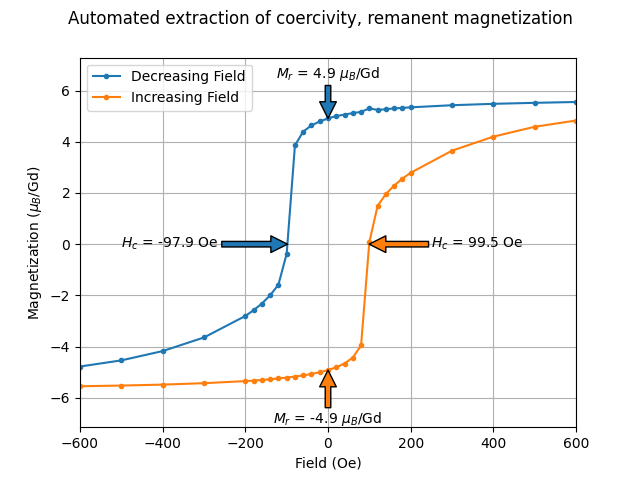

Text(0, -7, '$M_r$ = -4.9 $\\mu_B$/Gd')

In [17]:
# extracting coercivity, remanent magnetization
# use average of measurements repeated at same field (already done in .ndat files)
# 4 measurements done at each set field
avg_field = mh_data_5k['Field_Oe'].reshape(-1, 4).mean(axis = 1)
substrate_moment = substrate_susceptibility * substrate_volume * avg_field
avg_mag = cf*(mh_data_5k['Long_Moment_emu'].reshape(-1, 4).mean(axis = 1) - substrate_moment)

# separate field down/up splitting data halfway
N = avg_field.shape[0]//2
fig, ax = plt.subplots(1, 1)
fig.suptitle('Automated extraction of coercivity, remanent magnetization')
ax.plot(avg_field[:N], avg_mag[:N], marker = '.', c = 'C0', label = 'Decreasing Field')
ax.plot(avg_field[N:], avg_mag[N:], marker = '.', c = 'C1', label = 'Increasing Field')
ax.set_xlim(-600, 600)
ax.set_xlabel('Field (Oe)')
ax.set_ylabel(r'Magnetization ($\mu_B$/Gd)')
ax.grid()
ax.legend()

f_down = scipy.interpolate.interp1d(avg_field[:N], avg_mag[:N],
                                    kind = 'cubic', fill_value = 'extrapolate')
H_c = scipy.optimize.fsolve(f_down, 0)[0]
M_r = f_down(0)
ax.annotate(fr'$H_c$ = {H_c:.1f} Oe', (H_c, 0), xytext = (-500, 0),
           arrowprops = {}, va = 'center')
ax.annotate(fr'$M_r$ = {M_r:.1f} $\mu_B$/Gd', (0, M_r), xytext = (0, 6.5),
           arrowprops = {}, ha = 'center')

f_up = scipy.interpolate.interp1d(avg_field[N:], avg_mag[N:],
                                    kind = 'cubic', fill_value = 'extrapolate')
H_c = scipy.optimize.fsolve(f_up, 0)[0]
M_r = f_up(0)
ax.annotate(fr'$H_c$ = {H_c:.1f} Oe', (H_c, 0), xytext = (250, 0),
           arrowprops = {'facecolor': 'C1'}, va = 'center')
ax.annotate(fr'$M_r$ = {M_r:.1f} $\mu_B$/Gd', (0, M_r), xytext = (0, -7),
           arrowprops = {'facecolor': 'C1'}, ha = 'center')